In [ ]:
Flight Delay Forecasting — EUROCONTROL ANSP Dataset

**Goal:** Predict daily en-route flight delays using EUROCONTROL ANSP data (2020–2024).  
Accurate forecasting of delays helps airlines, airports, and air navigation service providers optimize resources, reduce congestion, and minimize passenger disruptions.

**Key steps in this notebook:**
- Load & clean historical delay data
- Aggregate daily delays
- Analyze patterns and trends
- Build & evaluate a forecasting model (SARIMA)
- Derive operational insights for decision-makers


In [35]:
# Core
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Utils
from glob import glob
import warnings, os
warnings.filterwarnings("ignore")
import bz2
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 100)


In [11]:
from glob import glob
files = sorted(glob("ert_dly_ansp_*.csv.bz2"))
print(files)


['ert_dly_ansp_2020.csv.bz2', 'ert_dly_ansp_2021.csv.bz2', 'ert_dly_ansp_2023.csv.bz2', 'ert_dly_ansp_2024.csv.bz2']


In [12]:
# Merge all years
dfs = []
for f in files:
    df_year = pd.read_csv(f, compression="bz2")  # pandas handles bz2 directly
    df_year["YEAR_FILE"] = os.path.basename(f).split("_")[-1].split(".")[0]
    dfs.append(df_year)

raw = pd.concat(dfs, ignore_index=True)
print("✅ Rows:", len(raw))
raw.head()


✅ Rows: 50628


,YEAR,MONTH_NUM,MONTH_MON,FLT_DATE,ENTITY_NAME,ENTITY_TYPE,FLT_ERT_1,DLY_ERT_1,DLY_ERT_A_1,DLY_ERT_C_1,DLY_ERT_D_1,DLY_ERT_E_1,DLY_ERT_G_1,DLY_ERT_I_1,DLY_ERT_M_1,DLY_ERT_N_1,DLY_ERT_O_1,DLY_ERT_P_1,DLY_ERT_R_1,DLY_ERT_S_1,DLY_ERT_T_1,DLY_ERT_V_1,DLY_ERT_W_1,DLY_ERT_NA_1,FLT_ERT_1_DLY,FLT_ERT_1_DLY_15,YEAR_FILE
0,2020,1,JAN,2020-01-01T00:00:00Z,Albcontrol,ANSP (AUA),383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
1,2020,1,JAN,2020-01-01T00:00:00Z,ANA LUX,ANSP (AUA),130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
2,2020,1,JAN,2020-01-01T00:00:00Z,ANS CR,ANSP (AUA),1599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
3,2020,1,JAN,2020-01-01T00:00:00Z,ANS Finland,ANSP (AUA),556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
4,2020,1,JAN,2020-01-01T00:00:00Z,ARMATS,ANSP (AUA),186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020


In [ ]:
Minimal cleaning & target creation

Date column is FLT_DATE (UTC ISO format).

Total en-route delay is typically FLT_ERT_1_DLY (minutes).

If that column is missing, we’ll fall back to summing all DLY_ERT_* columns.

In [36]:
# Ensure datetime
raw["FLT_DATE"] = pd.to_datetime(raw["FLT_DATE"], errors="coerce")
raw = raw.dropna(subset=["FLT_DATE"]).sort_values("FLT_DATE")


delay_col = None
if "FLT_ERT_1_DLY" in raw.columns:
    delay_col = "FLT_ERT_1_DLY"
else:
    
    dly_cols = [c for c in raw.columns if c.upper().startswith("DLY_ERT_")]
    if len(dly_cols) == 0:
        raise ValueError("Could not find a total delay column. Expected FLT_ERT_1_DLY or DLY_ERT_* columns.")
    raw["TOTAL_DELAY_FALLBACK"] = raw[dly_cols].sum(axis=1, skipna=True)
    delay_col = "TOTAL_DELAY_FALLBACK"

# Clean target (minutes)
raw[delay_col] = raw[delay_col].fillna(0)

# Aggregate to daily total delay across entities
daily = (
    raw.groupby("FLT_DATE", as_index=False)[delay_col]
       .sum()
       .rename(columns={"FLT_DATE":"DATE", delay_col:"TOTAL_DELAY"})
)

# Regularize daily frequency 
daily = (daily.set_index("DATE")
               .asfreq("D")
               .fillna(0)
               .reset_index())

daily.head()


,DATE,TOTAL_DELAY
0,2020-01-01 00:00:00+00:00,1011.0
1,2020-01-02 00:00:00+00:00,3254.0
2,2020-01-03 00:00:00+00:00,1954.0
3,2020-01-04 00:00:00+00:00,6049.0
4,2020-01-05 00:00:00+00:00,4186.0


In [ ]:
EDA

        TOTAL_DELAY
count   1827.000000
mean    2798.835796
std     5879.951282
min        0.000000
25%        0.000000
50%       36.000000
75%     2587.500000
max    35210.000000


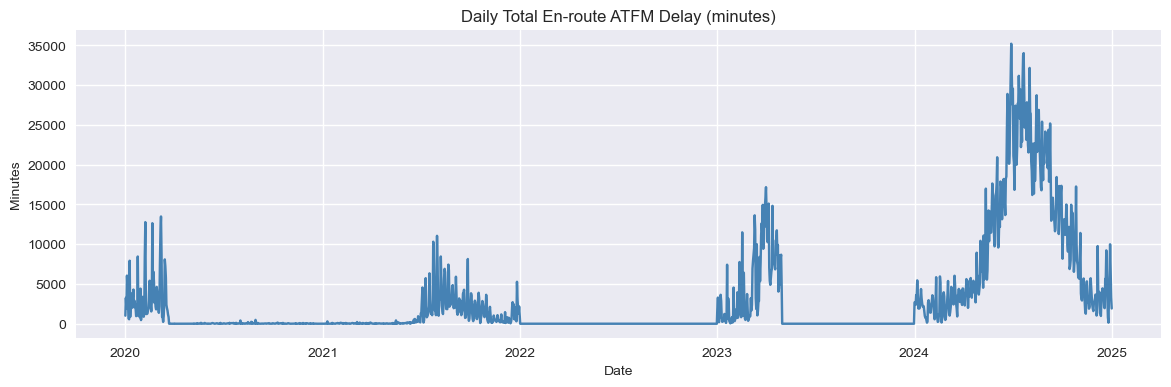

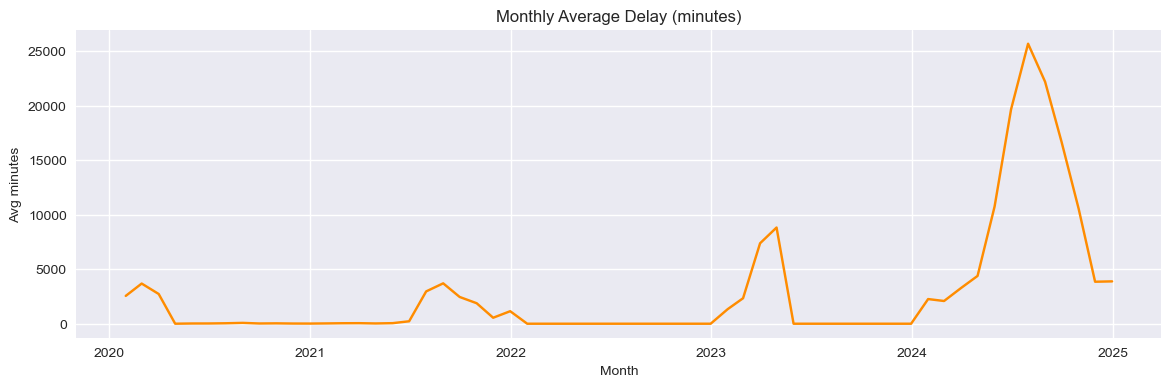

In [37]:
print(daily.describe())

plt.figure(figsize=(14,4))
plt.plot(daily["DATE"], daily["TOTAL_DELAY"], color="steelblue")
plt.title("Daily Total En-route ATFM Delay (minutes)")
plt.xlabel("Date"); plt.ylabel("Minutes"); plt.grid(True); plt.show()

# Monthly average
monthly = daily.set_index("DATE")["TOTAL_DELAY"].resample("M").mean()
plt.figure(figsize=(14,4))
plt.plot(monthly.index, monthly.values, color="darkorange")
plt.title("Monthly Average Delay (minutes)")
plt.xlabel("Month"); plt.ylabel("Avg minutes"); plt.grid(True); plt.show()


In [ ]:
Feature engineering (time features + lags/rolls)

XGBoost likes informative features. We’ll add:

calendar: day_of_week, month, weekend

lags: lag_1, lag_7

rolling stats: rolling_mean_7, rolling_std_7 (based on prior days)

In [38]:
df = daily.copy()
df["day_of_week"] = df["DATE"].dt.dayofweek
df["month"] = df["DATE"].dt.month
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)

# Lags (use shift so we don't peek into the future)
df["lag_1"] = df["TOTAL_DELAY"].shift(1)
df["lag_7"] = df["TOTAL_DELAY"].shift(7)

# Rolling window features (shifted 1 so they don't include today)
df["rolling_mean_7"] = df["TOTAL_DELAY"].shift(1).rolling(7).mean()
df["rolling_std_7"]  = df["TOTAL_DELAY"].shift(1).rolling(7).std()

# Drop early rows with NaNs due to shifting
df = df.dropna().reset_index(drop=True)
df.head()


,DATE,TOTAL_DELAY,day_of_week,month,is_weekend,lag_1,lag_7,rolling_mean_7,rolling_std_7
0,2020-01-08 00:00:00+00:00,558.0,2,1,0,654.0,1011.0,2821.000000,1880.935051
1,2020-01-09 00:00:00+00:00,7920.0,3,1,0,558.0,3254.0,2756.285714,1959.730144
2,2020-01-10 00:00:00+00:00,860.0,4,1,0,7920.0,1954.0,3422.857143,2779.366140
3,2020-01-11 00:00:00+00:00,2725.0,5,1,1,860.0,6049.0,3266.571429,2903.703833
4,2020-01-12 00:00:00+00:00,2040.0,6,1,1,2725.0,4186.0,2791.714286,2631.917597


In [ ]:
Time-based train/test split

We’ll use an 80/20 chronological split.

In [39]:
FEATURES = ["day_of_week","month","is_weekend","lag_1","lag_7","rolling_mean_7","rolling_std_7"]

X = df[FEATURES]
y = df["TOTAL_DELAY"]

split_idx = int(len(df)*0.80)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_train.shape, X_test.shape


((1456, 7), (364, 7))

In [ ]:
Train XGBoost regressor

In [40]:
model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    reg_alpha=0.0,
    reg_lambda=1.0,
    n_jobs=-1
)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
Evaluate (MAE / RMSE / MAPE*) & visualize

Adjusted MAPE: exclude zero-actual days to avoid division-by-zero explosions 

In [41]:
y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mask = y_test != 0
mape = (np.abs(y_test[mask] - y_pred[mask]) / y_test[mask]).mean() * 100

print(f"MAE:  {mae:,.2f} minutes")
print(f"RMSE: {rmse:,.2f} minutes")
print(f"Adjusted MAPE (excl. zeros): {mape:.2f}%")


MAE:  5,565.64 minutes
RMSE: 8,787.26 minutes
Adjusted MAPE (excl. zeros): 61.58%


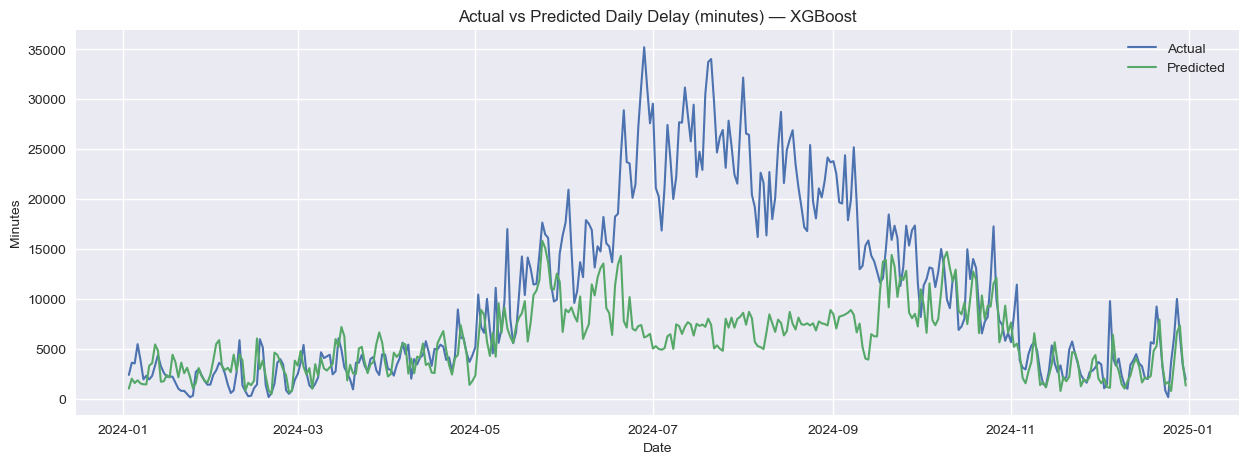

In [19]:
# Plot actual vs predicted (indexed by time)
t_index = df["DATE"].iloc[split_idx:].reset_index(drop=True)

plt.figure(figsize=(15,5))
plt.plot(t_index, y_test.values, label="Actual", linewidth=1.5)
plt.plot(t_index, y_pred, label="Predicted", linewidth=1.5)
plt.title("Actual vs Predicted Daily Delay (minutes) — XGBoost")
plt.xlabel("Date"); plt.ylabel("Minutes"); plt.grid(True); plt.legend(); plt.show()


In [ ]:
Feature importance (model native)

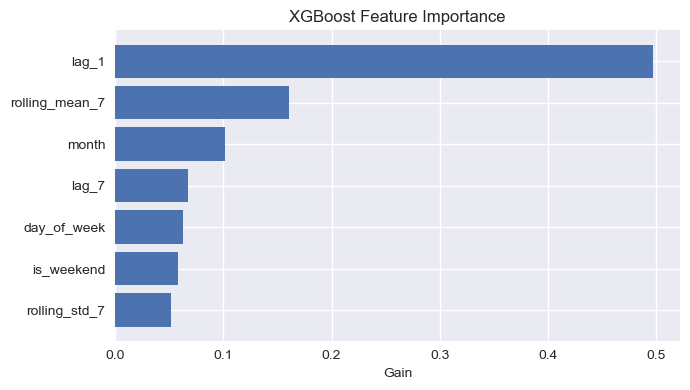

In [20]:
importances = model.feature_importances_
order = np.argsort(importances)

plt.figure(figsize=(7,4))
plt.barh(np.array(FEATURES)[order], importances[order])
plt.title("XGBoost Feature Importance")
plt.xlabel("Gain"); plt.tight_layout(); plt.show()


In [ ]:
Forecast Next Days

In [26]:
# Forecast for next 7 days with calendar + lag features
future = df.copy()   

for i in range(7):
   
    last_date = future["DATE"].iloc[-1] + pd.Timedelta(days=1)

   
    new_data = {}

    # Calendar features
    new_data["day_of_week"] = last_date.dayofweek
    new_data["month"] = last_date.month
    new_data["is_weekend"] = 1 if last_date.dayofweek in [5, 6] else 0

    # Lag features — based on the previous forecasted or actual delays
    new_data["lag_1"] = future["TOTAL_DELAY"].iloc[-1]
    new_data["lag_7"] = future["TOTAL_DELAY"].iloc[-7] if len(future) >= 7 else new_data["lag_1"]

    # Rolling features
    tail_values = future["TOTAL_DELAY"].tail(7)
    new_data["rolling_mean_7"] = tail_values.mean()
    new_data["rolling_std_7"] = tail_values.std()

    # Convert to dataframe
    new_row = pd.DataFrame([new_data], index=[last_date])

    # Predict the next day delay
    y_future = model.predict(new_row[FEATURES])[0]

    # Append predicted value as TOTAL_DELAY (so next step can use it for lags)
    new_row["TOTAL_DELAY"] = y_future
    new_row["DATE"] = last_date

    future = pd.concat([future, new_row], ignore_index=True)

future.tail(10)



,DATE,TOTAL_DELAY,day_of_week,month,is_weekend,lag_1,lag_7,rolling_mean_7,rolling_std_7
1817,2024-12-29 00:00:00+00:00,6334.000000,6,12,1,9986.000000,6633.0,4375.285714,3466.818557
1818,2024-12-30 00:00:00+00:00,3328.000000,0,12,0,6334.000000,3261.0,4332.571429,3436.070957
1819,2024-12-31 00:00:00+00:00,1918.000000,1,12,0,3328.000000,799.0,4342.142857,3432.680169
1820,2025-01-01 00:00:00+00:00,1383.909912,2,1,0,1918.000000,135.0,4502.000000,3261.990343
1821,2025-01-02 00:00:00+00:00,2726.794189,3,1,0,1383.909912,3690.0,4680.415702,3007.558746
1822,2025-01-03 00:00:00+00:00,3498.793701,4,1,0,2726.794189,6123.0,4542.814872,3081.548136
1823,2025-01-04 00:00:00+00:00,5138.723145,5,1,1,3498.793701,9986.0,4167.928258,3016.202050
1824,2025-01-05 00:00:00+00:00,3148.036621,6,1,1,5138.723145,6334.0,3475.460135,1747.414664
1825,2025-01-06 00:00:00+00:00,2115.774658,0,1,0,3148.036621,3328.0,3020.322510,1211.517798
1826,2025-01-07 00:00:00+00:00,1982.073486,1,1,0,2115.774658,1918.0,2847.147461,1246.345754


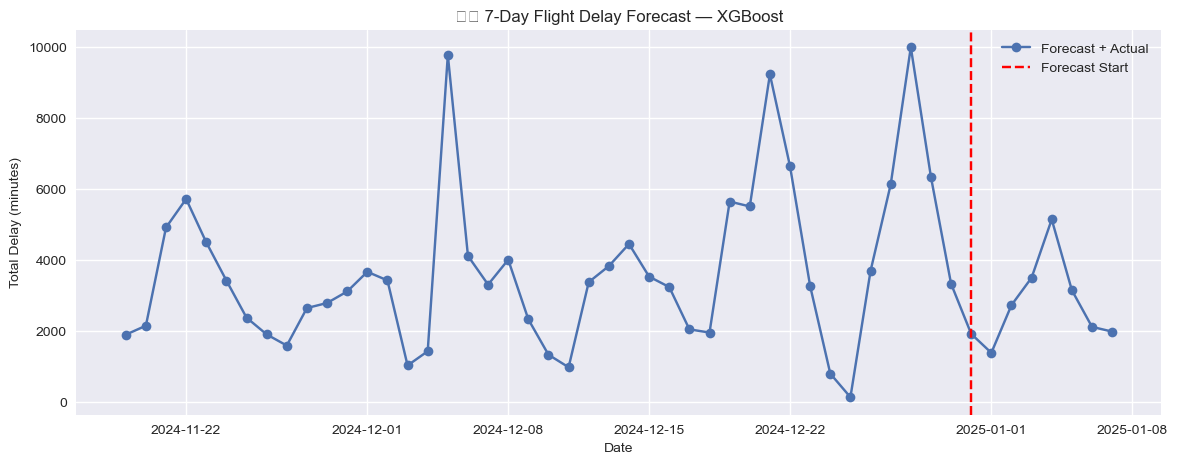

In [27]:
future_plot = future.set_index("DATE")["TOTAL_DELAY"].tail(50) 

plt.figure(figsize=(14,5))
plt.plot(future_plot.index, future_plot.values, marker='o', label="Forecast + Actual")
plt.axvline(future["DATE"].iloc[-8], color='red', linestyle='--', label="Forecast Start")
plt.title("✈️ 7-Day Flight Delay Forecast — XGBoost")
plt.ylabel("Total Delay (minutes)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
tuning existing model with GridSearchCV

In [42]:
#imports
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [47]:
#Define Parameter Grid
#param_grid = {
 #   'n_estimators': [300, 600, 1000],
  #  'learning_rate': [0.01, 0.05, 0.1],
   # 'max_depth': [4, 6, 8],
    #'subsample': [0.8, 1.0],
    #'colsample_bytree': [0.8, 1.0],
    #'reg_lambda': [1, 2],
    #'reg_alpha': [0, 1]
#}
param_grid = {
    'n_estimators': [300, 600],       # fewer values
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_lambda': [1],
    'reg_alpha': [0]
}


In [48]:
#Initialize Base Model and GridSearchCV
base_model = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=2,                  
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)


In [49]:
fit_params = {
    "early_stopping_rounds": 20,
    "eval_metric": "rmse",
    "eval_set": [(X_test, y_test)],
    "verbose": False
}

grid_search.fit(X_train, y_train, **fit_params)

print("✅ Best RMSE score:", -grid_search.best_score_)
print("🏆 Best parameters:", grid_search.best_params_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
✅ Best RMSE score: 1355.1037358398398
🏆 Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}


In [50]:
#Evaluate the Best Model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mask = y_test != 0
mape_best = (np.abs(y_test[mask] - y_pred_best[mask]) / y_test[mask]).mean() * 100

print(f" MAE:  {mae_best:,.2f} min")
print(f" RMSE: {rmse_best:,.2f} min")
print(f" Adjusted MAPE: {mape_best:.2f}%")


 MAE:  5,058.58 min
 RMSE: 8,160.17 min
 Adjusted MAPE: 51.42%


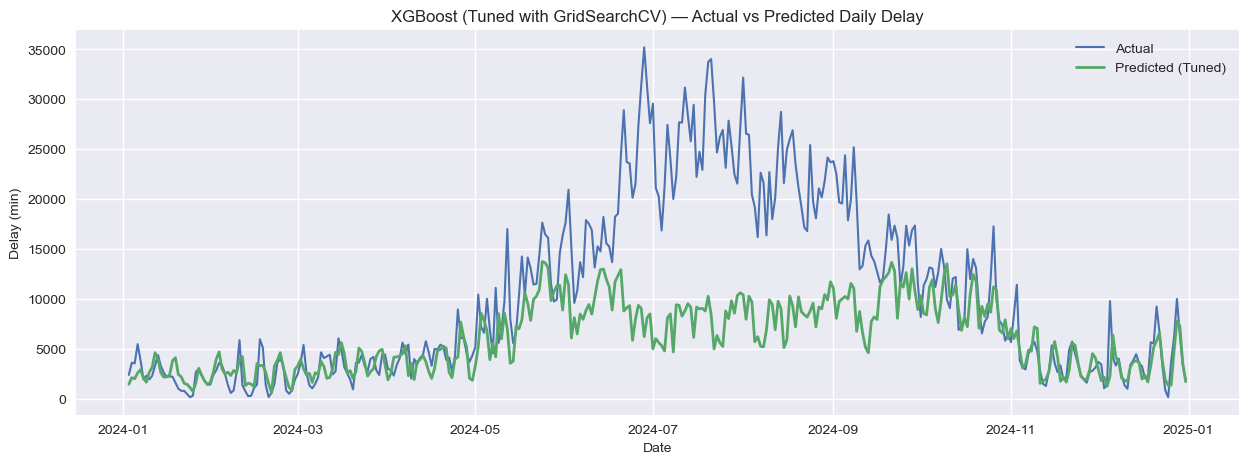

In [51]:
#Plot Actual vs Predicted After Tuning

t_index = df["DATE"].iloc[split_idx:].reset_index(drop=True)
plt.figure(figsize=(15,5))
plt.plot(t_index, y_test.values, label="Actual", linewidth=1.5)
plt.plot(t_index, y_pred_best, label="Predicted (Tuned)", linewidth=2)
plt.title("XGBoost (Tuned with GridSearchCV) — Actual vs Predicted Daily Delay")
plt.xlabel("Date"); plt.ylabel("Delay (min)")
plt.legend(); plt.grid(True); plt.show()